In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd


from rBoltzMach import boltzmanmachine
from metrics import pair_error, sequence_error, JS_divergence, p
plt.rcParams['font.size'] = 14

In [2]:
a=0.05
b=str(a)
b.replace('.','')

'005'

## Data selection

In [2]:
CASE=1           #select the data to be analysed
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
    
fname=dname+'/x_RBM_q0.1.dat'
v = np.loadtxt(fname, delimiter=" ",dtype=int)
v0 = np.copy(v)  #Copy original data to analyse later

In [3]:
perror = pair_error(v0, spin=False)
serror = sequence_error(v0, spin=False, vmin=0)
print(perror, serror)


9.457500000000001 22.6


## Network parameters

In [4]:
N = len(v)       #Number of rows
L = len(v[0])    #Set the number of visible variable
M = 6            #Set the number of hidden units

sigma = np.sqrt(4. / float(L + M))

print(f'each of N={N} data has L={L} digits')
print(f'The network has {L} visible units and {M} hidden units')
print(f'Initializing std {sigma}')

each of N=10000 data has L=20 digits
The network has 20 visible units and 6 hidden units
Initializing std 0.3922322702763681


## Defining training parameters

In [5]:
seed = 1      #set the random seed in order to reproduce results 
Amp_training  = 0.05      #set the coefficient that multiply the temp, Higher Amp -> Lower Temp
cdn  = 1        #set the number of phases


n_epochs = 100   #set the number of epochs


spin = True      #chose the kind of representation

if spin:
    GAP=2        #sigmoid takes into account energy difference =2
    v = 2*v - 1  #convert 0,1 -> -1,1
    vmin=-1
else:
    GAP=1
    vmin=0

## Initialize the Restricted Boltzmann Machine

In [6]:
np.random.seed(seed)
rbm = boltzmanmachine(L,M,sigma)

## Model Training

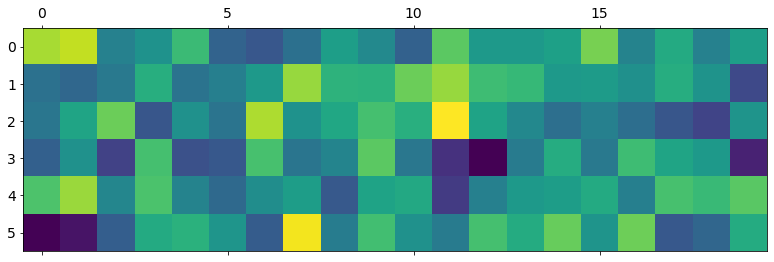

10


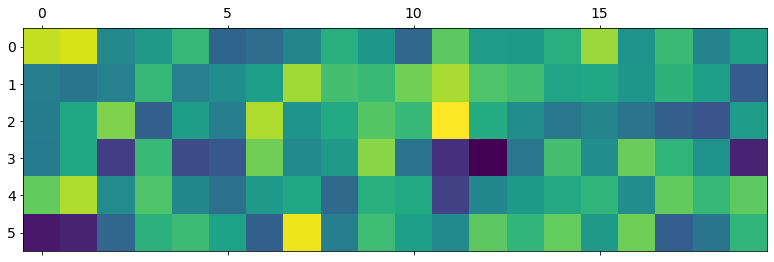

20


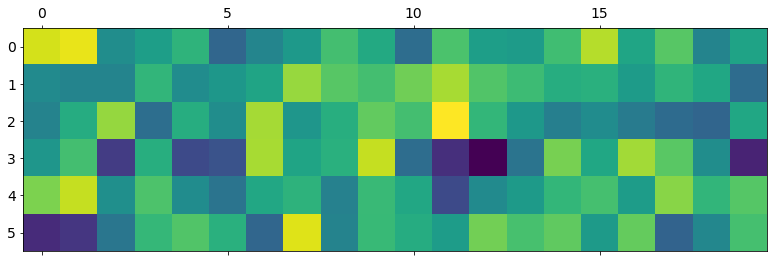

30


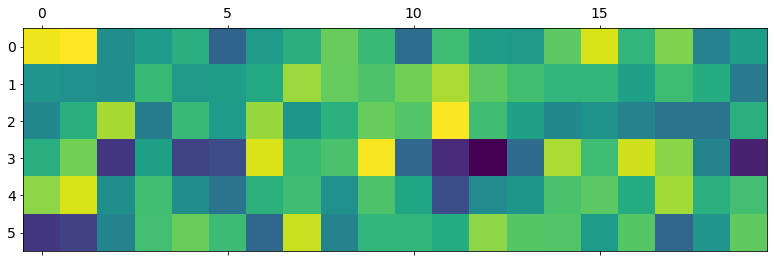

40


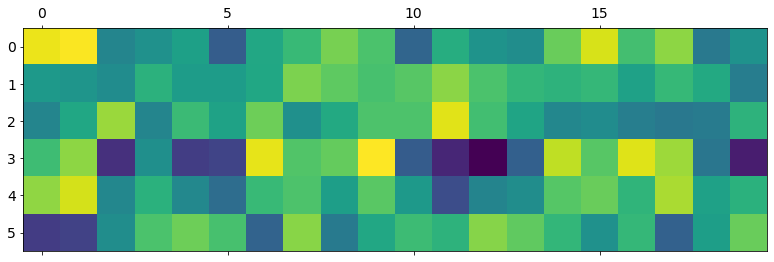

50


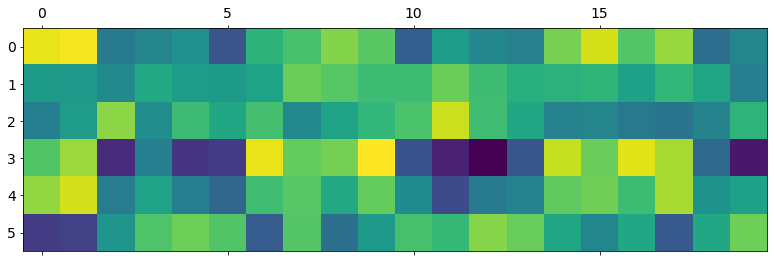

60


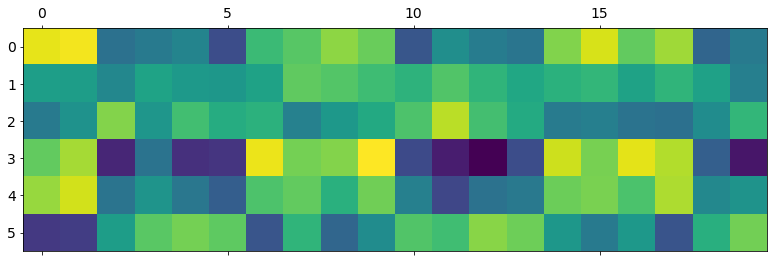

70


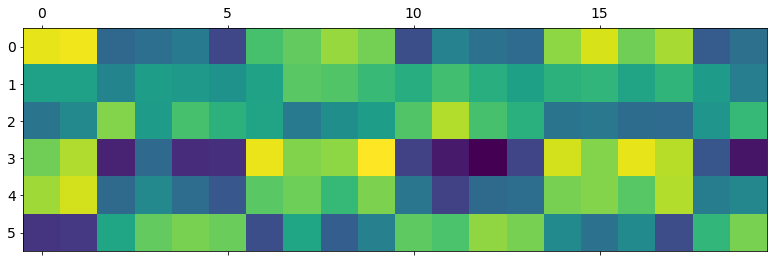

80


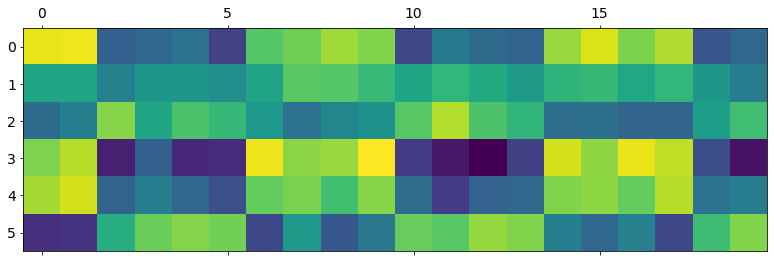

90


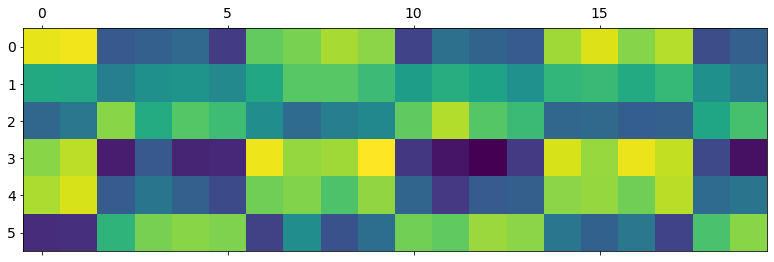

100


In [7]:
# random seed for reproducibility
np.random.seed(seed)

# learning rate
l_rate = 1e-3

# minibatch
mini_batch = 500

# train model
print('===================================================')
for epoch in range(n_epochs):
    # aggregate normalization of batch statistics and learning rate
    for k in range(N):
        rbm.train(data=v[k],
                  learning_rate=l_rate,
                  batch_size=mini_batch,
                  n_contrastive_div=cdn,
                  Amp_training=Amp_training,
                  Algorithm='RMSprop')
    
    # randomize the order of input data
    np.random.shuffle(v)
    if epoch%10==9:
        plt.matshow(rbm.w.T)
        plt.show()
        print(epoch+1)

## Save model into .npz file containing multiple arrays

In [8]:
file_name='Models/rbm'+str(A_training)+'.npz'
rbm.save_model(file_name)

## Load a previewsly saved model from a .npz file

In [9]:
file_name='test.npz'
rbm_test = boltzmanmachine(L,M,sigma)
rbm_test.load_model(file_name)

## Generating fantasy data in order to test the model

In [10]:
Amp_gen = 0.5

vf = rbm.gen_fantasy(v0, Amp_gen)



## Evaluating Pair-wise errors, Sequence error, Jensen-Shannon Divergence

In [11]:
perror = pair_error(vf, spin=True)
serror = sequence_error(vf, spin=True, vmin=vmin)
print(perror, serror)


0.3875 0.77


In [12]:
p = p(vf)
q = np.ones((5,4))*0.25

In [13]:
p = np.reshape(p, (5,4))
print(p)
print(q)

[[0.2001 0.3111 0.4425 0.0463]
 [0.48   0.0147 0.0751 0.4302]
 [0.4908 0.0173 0.0587 0.4332]
 [0.4858 0.0079 0.021  0.4853]
 [0.0081 0.5014 0.0205 0.47  ]]
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


In [14]:
JS_divergence(p,q)

0.6331307123182188

In [32]:
#function that plots for % autovectors of the energy as a function of the position on the protein  
def distr_ami(v):
    
    v = (v+1)/2
    
    csi1 = np.array([1,0,0,0])    
    csi2 = np.array([0,1,0,0])   
    csi3 = np.array([0,0,1,0])    
    csi4 = np.array([0,0,0,1])

    #ami_disteach is a matrix, every row is a protein, each entrance of the row will be filled with the autovector assosiated 
    #with the aminoacid in that position. Initially it is set to zeros
    ami_distr = np.zeros((10000,5), dtype=int)

    #assign to every amino acid its autovector as a single number
    #for example if the aminoacid==csi2 than the position of the aminoacid in the ami_distr is filled with a 2
    for i in range(len(v)):
            aminoacids = np.reshape(np.array(v[i, :]), (5,4))
            for a in range(5): 
                if np.array_equal(aminoacids[a], csi1):
                    ami_distr[i,a] = 1
                elif np.array_equal(aminoacids[a], csi2):
                    ami_distr[i,a] = 2
                elif np.array_equal(aminoacids[a], csi3):
                    ami_distr[i,a] = 3
                elif np.array_equal(aminoacids[a], csi4):
                    ami_distr[i,a] = 4

    print('Type of amino acids in the proteins:', '\n','\n', ami_distr)

    label = ['csi1', 'csi2', 'csi3', 'csi4']
    bar_labels = ['polar', 'polar', 'apolar', 'apolar']
    bar_colors = ['tab:red', 'tab:red', 'tab:blue', 'tab:blue']

    fig, axs = plt.subplots(5)
    fig.set_size_inches(5,15)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

    for i in range(5):
        _, counts = np.unique(ami_distr[:,i], return_counts=True)
        axs[i].bar(label, (counts/10000)*100, label=bar_labels, color=bar_colors)
        axs[i].set_ylabel('%')
        axs[i].set_xlabel('Amino acid')
        axs[i].set_title('Position in the protein '+f'{i+1}')
        box = axs[i].get_position()
        axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].grid(linestyle=':')
        
    
    fig.savefig('Amp_train.png')



In [ ]:
#function that plots for % autovectors of the energy as a function of the position on the protein  
def distr_ami(v):
    
    v = (v+1)/2
    
    csi1 = np.array([1,0,0,0])    
    csi2 = np.array([0,1,0,0])   
    csi3 = np.array([0,0,1,0])    
    csi4 = np.array([0,0,0,1])

    #ami_disteach is a matrix, every row is a protein, each entrance of the row will be filled with the autovector assosiated 
    #with the aminoacid in that position. Initially it is set to zeros
    ami_distr = np.zeros((10000,5), dtype=int)

    #assign to every amino acid its autovector as a single number
    #for example if the aminoacid==csi2 than the position of the aminoacid in the ami_distr is filled with a 2
    for i in range(len(v)):
            aminoacids = np.reshape(np.array(v[i, :]), (5,4))
            for a in range(5): 
                if np.array_equal(aminoacids[a], csi1):
                    ami_distr[i,a] = 1
                elif np.array_equal(aminoacids[a], csi2):
                    ami_distr[i,a] = 2
                elif np.array_equal(aminoacids[a], csi3):
                    ami_distr[i,a] = 3
                elif np.array_equal(aminoacids[a], csi4):
                    ami_distr[i,a] = 4

                    
    val_ami1, n_ami1 = np.unique(distr_ami[:,0], return_counts=True)
    print('Type of amino acids in the proteins:', '\n','\n', ami_distr)

    label = ['csi1', 'csi2', 'csi3', 'csi4']
    bar_labels = ['polar', 'polar', 'apolar', 'apolar']
    bar_colors = ['tab:red', 'tab:red', 'tab:blue', 'tab:blue']

    fig, axs = plt.subplots(5)
    fig.set_size_inches(5,15)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

    for i in range(5):
        _, counts = np.unique(ami_distr[:,i], return_counts=True)
        axs[i].bar(label, (counts/10000)*100, label=bar_labels, color=bar_colors)
        axs[i].set_ylabel('%')
        axs[i].set_xlabel('Amino acid')
        axs[i].set_title('Position in the protein '+f'{i+1}')
        box = axs[i].get_position()
        axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].grid(linestyle=':')
        
    
    fig.savefig('Amp_train.png')



Type of amino acids in the proteins: 
 
 [[1 4 1 4 2]
 [3 1 4 1 4]
 [2 4 1 4 2]
 ...
 [2 4 1 4 2]
 [2 3 1 4 2]
 [3 1 3 1 4]]


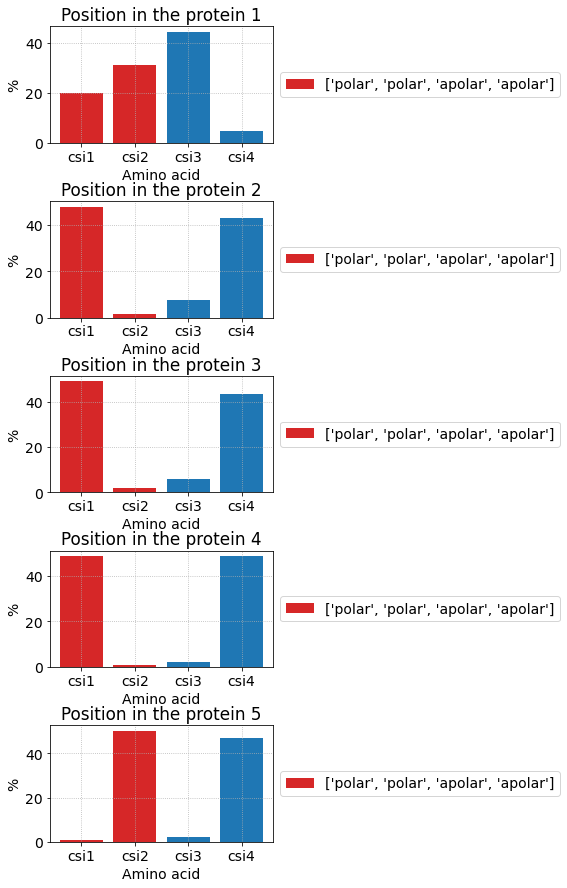

In [30]:
distr_ami(vf)